In [1]:
import numpy as np

from gradvi.normal_means import NormalMeans
from gradvi.optimize.root_find import vec_root
from gradvi.tests import toy_priors
from gradvi.tests import toy_data

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [3]:
prior = toy_priors.get_ash_scaled(k = 4, skbase = 0.2, sparsity = 0.6)
n = 100
z, sj2, s2, dj = toy_data.get_normal_means(
    prior, n = n, 
    dj = np.square(np.random.normal(1, 2, size = n)) * n
)
nm1 = NormalMeans.create(z, prior, sj2, scale = s2, d = dj)
b = nm1.analytical_posterior_mean

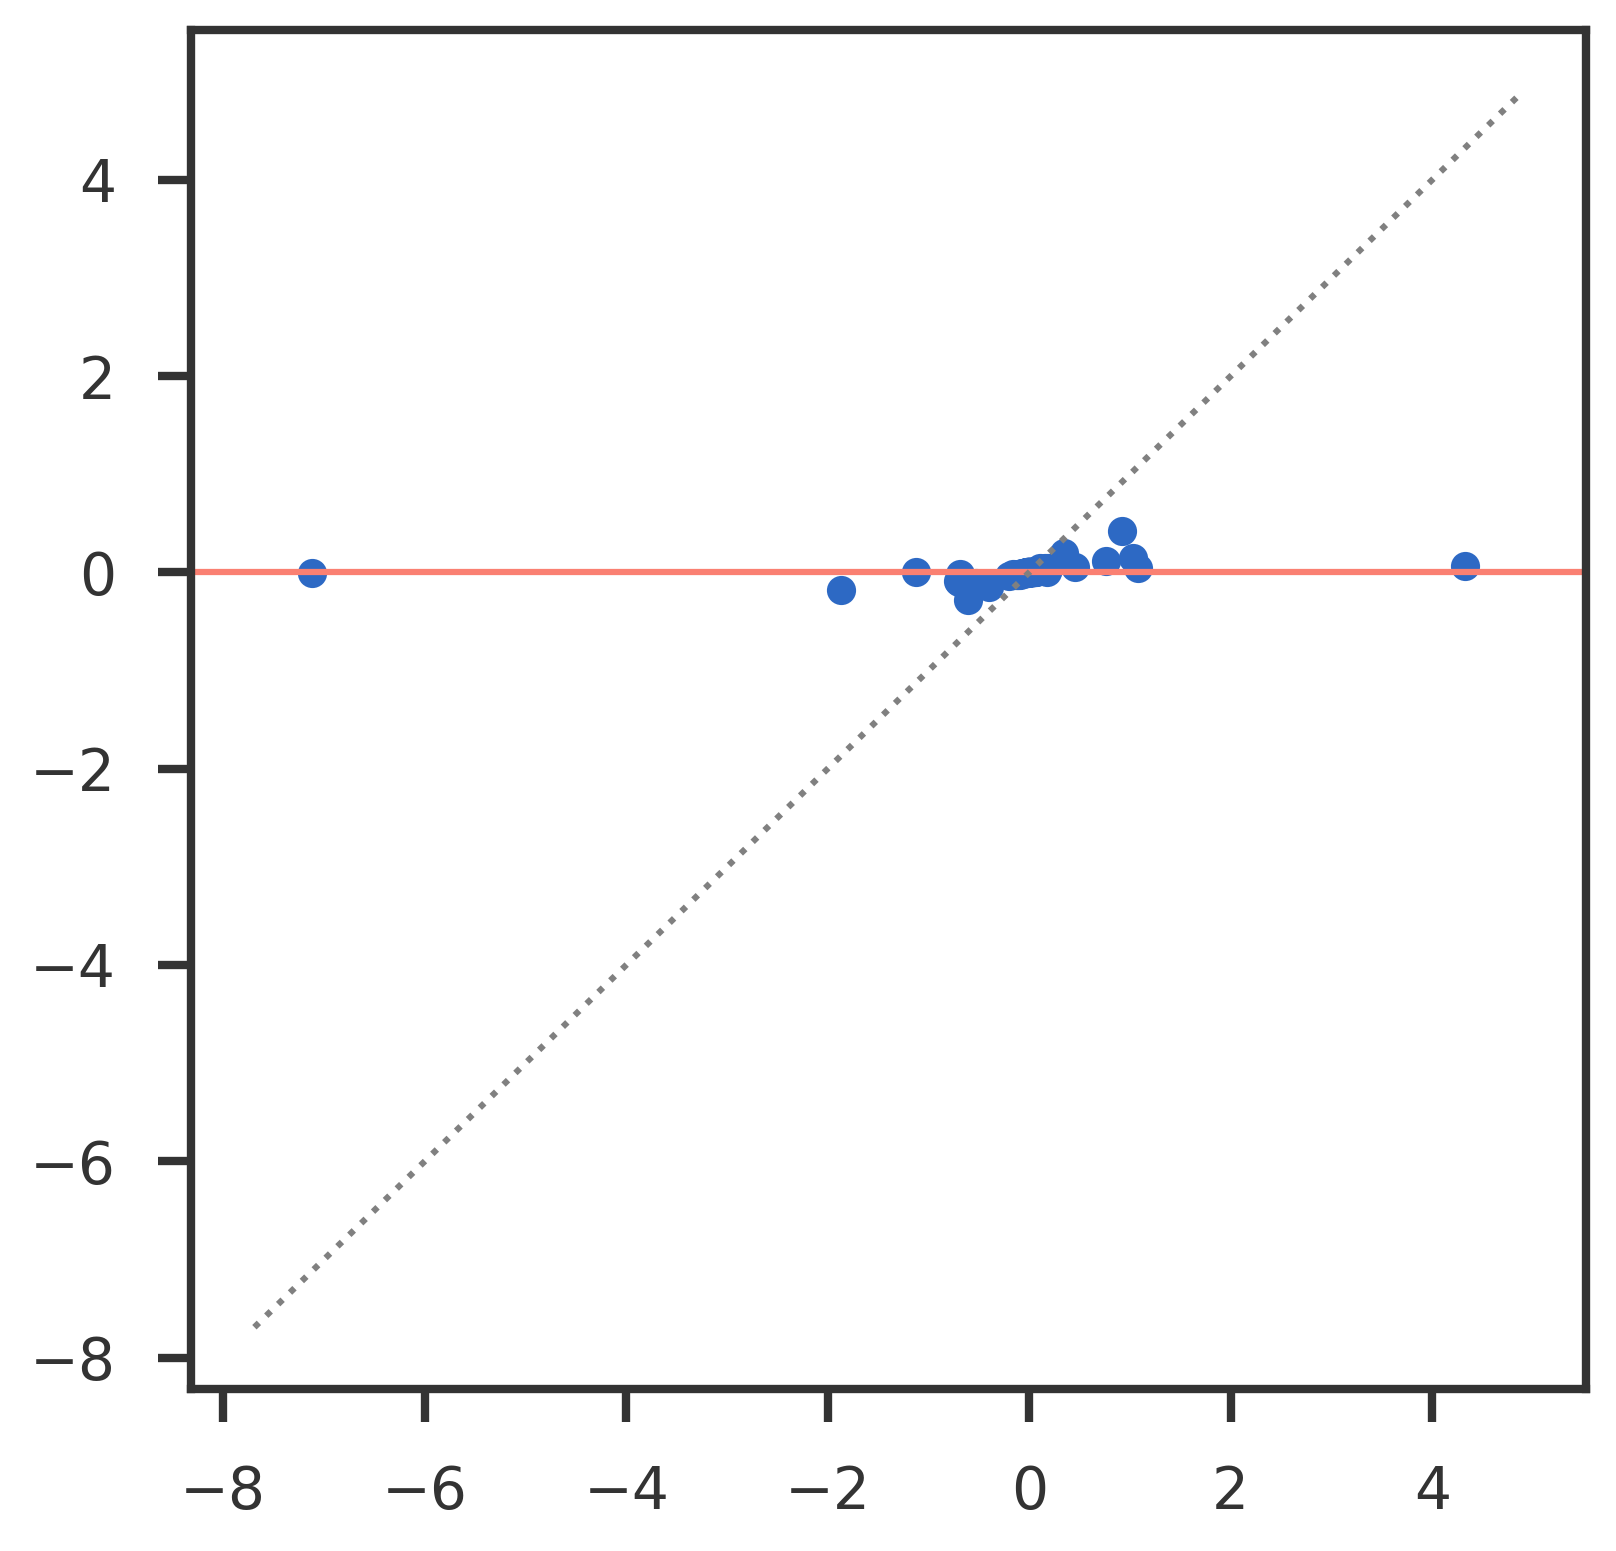

In [4]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(z, b)
ax1.axhline(y = 0, color = 'salmon')
mpl_utils.plot_diag(ax1)
plt.show()

In [5]:
def _rootfind_zero_func(x, _b, _p, _s, _sc, _d):
    nm = NormalMeans.create(x, _p, _s, scale = _sc, d = _d)
    fx = nm.shrinkage_operator(jac = False)
    return fx - _b

fixargs  = (prior, sj2, s2, dj)
fix1args = (prior, sj2[0], s2, dj[0])

In [6]:
def bracket_shrinkage(func, b, args = (), tol = 1e-4, gt_one = 1.603):
    """
    Find the brackets of a zero function from shrinkage operator, that is
        f(x) = M(x) - b
    Assumes shrinkage properties of M(), in particular M(b) < b for all b.
    Hence, it cannot be used for other general functions.
    
    Parameters
    ----------
    func : callable
        The shrinkage function f, which is called as ``func(x, b, *args)``
        
    b : ndarray
        The vector b for calling the function ``func``
        
    args : tuple, optional
        Other arguments for calling ``func``
        
    tol : float, optional
        Converges when f(xup) > tol and f(xlo) < -tol
        
    gt_one : float, optional
        A factor which will be multiplied with the estimate of xup 
        and xlo while searching the bracket.
        
    Returns
    -------
    xlo : ndarray
        Values of lower bracket such that f(xlo) < 0
        
    xup : ndarray
        Values of upper bracket such that f(xup) > 0
    """
    eps = np.std(b)   
    
    xup = b.copy()
    xlo = b.copy()
    ipos = np.where(b > 0)[0] # b is always 1d
    ineg = np.where(b < 0)[0]
    
    # If b is positive, f(b - eps) < 0 always
    xlo[ipos] -= eps
    
    # If b is negative, f(b + eps) > 0 always
    xup[ineg] += eps

    nfev = 0
    xup[ipos] *= gt_one
    xlo[ineg] *= gt_one
    
    xev = np.zeros_like(b)
    xev[ipos] = xup[ipos] * gt_one
    xev[ineg] = xlo[ineg] * gt_one
    
    while True:

        fx = func(xev, b, *args)
        nfev += 1
        fneg = np.where(fx < tol)[0] # fx is always 1d
        fpos = np.where(fx > -tol)[0]
        # Re-evaluate xup[ipos]
        _fneg = np.intersect1d(fneg, ipos)
        # Re-evaluate xlo[ineg]
        _fpos = np.intersect1d(fpos, ineg)
        uidx = np.concatenate((_fneg, _fpos))
        if uidx.shape[0] == 0:
            break
        xev[uidx] *= gt_one
            
    xup[ipos] = xev[ipos]
    xlo[ineg] = xev[ineg]
        
#     while True:
#         fxup_est = func(xup, b, *args)
#         nfev += 1
#         fneg = np.where(fxup_est < tol)[0] # fxup_est is alway 1d

#         if fneg.shape[0] == 0:
#             break
#         xup[fneg] *= gt_one

#     while True:
#         fxlo_est = func(xlo, b, *args)
#         nfev += 1
#         fpos = np.where(fxlo_est > -tol)[0]

#         if fpos.shape[0] == 0:
#             break
#         xlo[fpos] *= gt_one
        
    return xlo, xup, nfev

Number of function evaluations: 11
Evaluation status: True


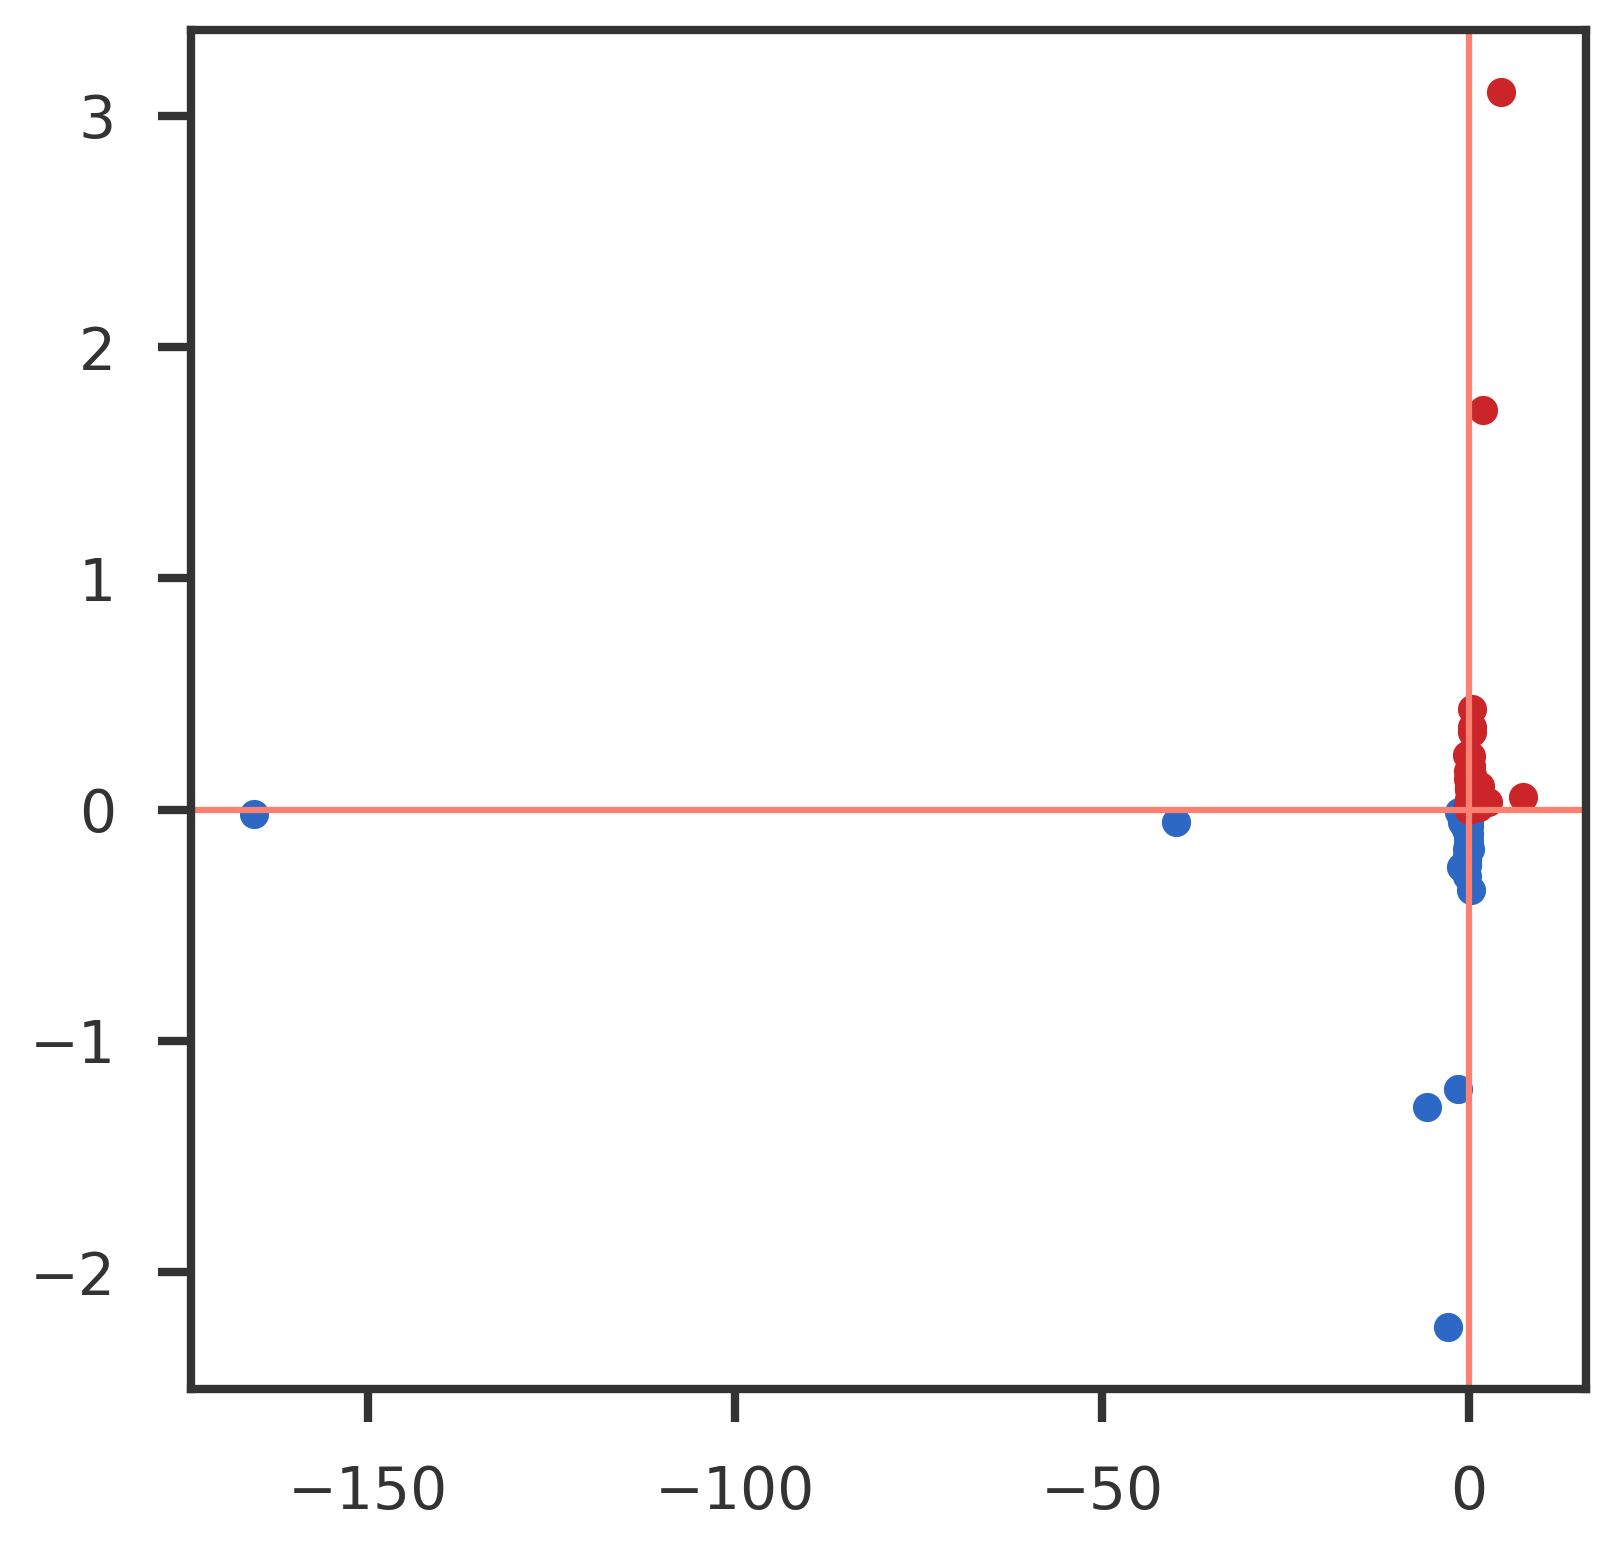

In [12]:
tol = 1e-2

xlo, xup, nfev = bracket_shrinkage(_rootfind_zero_func, b, fixargs, gt_one = 2.0 * 1.603, tol = 1e-2)
fxlo = _rootfind_zero_func(xlo, b, *fixargs)
fxup = _rootfind_zero_func(xup, b, *fixargs)

success = np.all(fxup > 0) and np.all(fxlo < 0)

print (f"Number of function evaluations: {nfev}")
print (f"Evaluation status: {success}")

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(xlo, fxlo)
ax1.scatter(xup, fxup)
#ax1.scatter(xup, fxup)
ax1.axhline(y = 0, color = 'salmon')
ax1.axvline(x = 0, color = 'salmon')
#mpl_utils.plot_diag(ax1)
plt.show()

Try with a single parameter

In [8]:
b1 = np.atleast_1d(-np.max(np.abs(b)))

x1lo, x1up, nfev = bracket_shrinkage(_rootfind_zero_func, b1, fix1args)

In [9]:
nfev

1

In [10]:
x1lo

array([-1.09242687])

In [11]:
x1up

array([-0.4251335])

In [13]:
mfunc = lambda x, b : x + b

In [14]:
mfunc(2, 2)

4

In [15]:
mfunc(3, 3)

6

[ 2  3  5  7  8 12 15 17 20 25 26 27 29 31 33 34 36 38 42 43 44 45 47 48
 49 50 51 52 57 64 70 74 76 79 82 83 86 87 88 89 90 92 93 94 96 97 98 99]
[ 2  3  5  7  8 12 15 17 20 25 26 27 29 31 33 34 36 38 42 43 44 45 47 48
 49 50 51 52 57 64 70 74 76 79 83 86 87 88 89 90 92 93 94 96 97 98 99]
Updating ipos values
[ 2  3  5  7  8 12 17 20 25 26 27 29 31 34 36 38 42 43 44 45 47 48 49 50
 51 52 57 64 70 74 76 79 83 86 87 88 89 90 92 93 94 96 97 98 99]
Number of function evaluations: 2


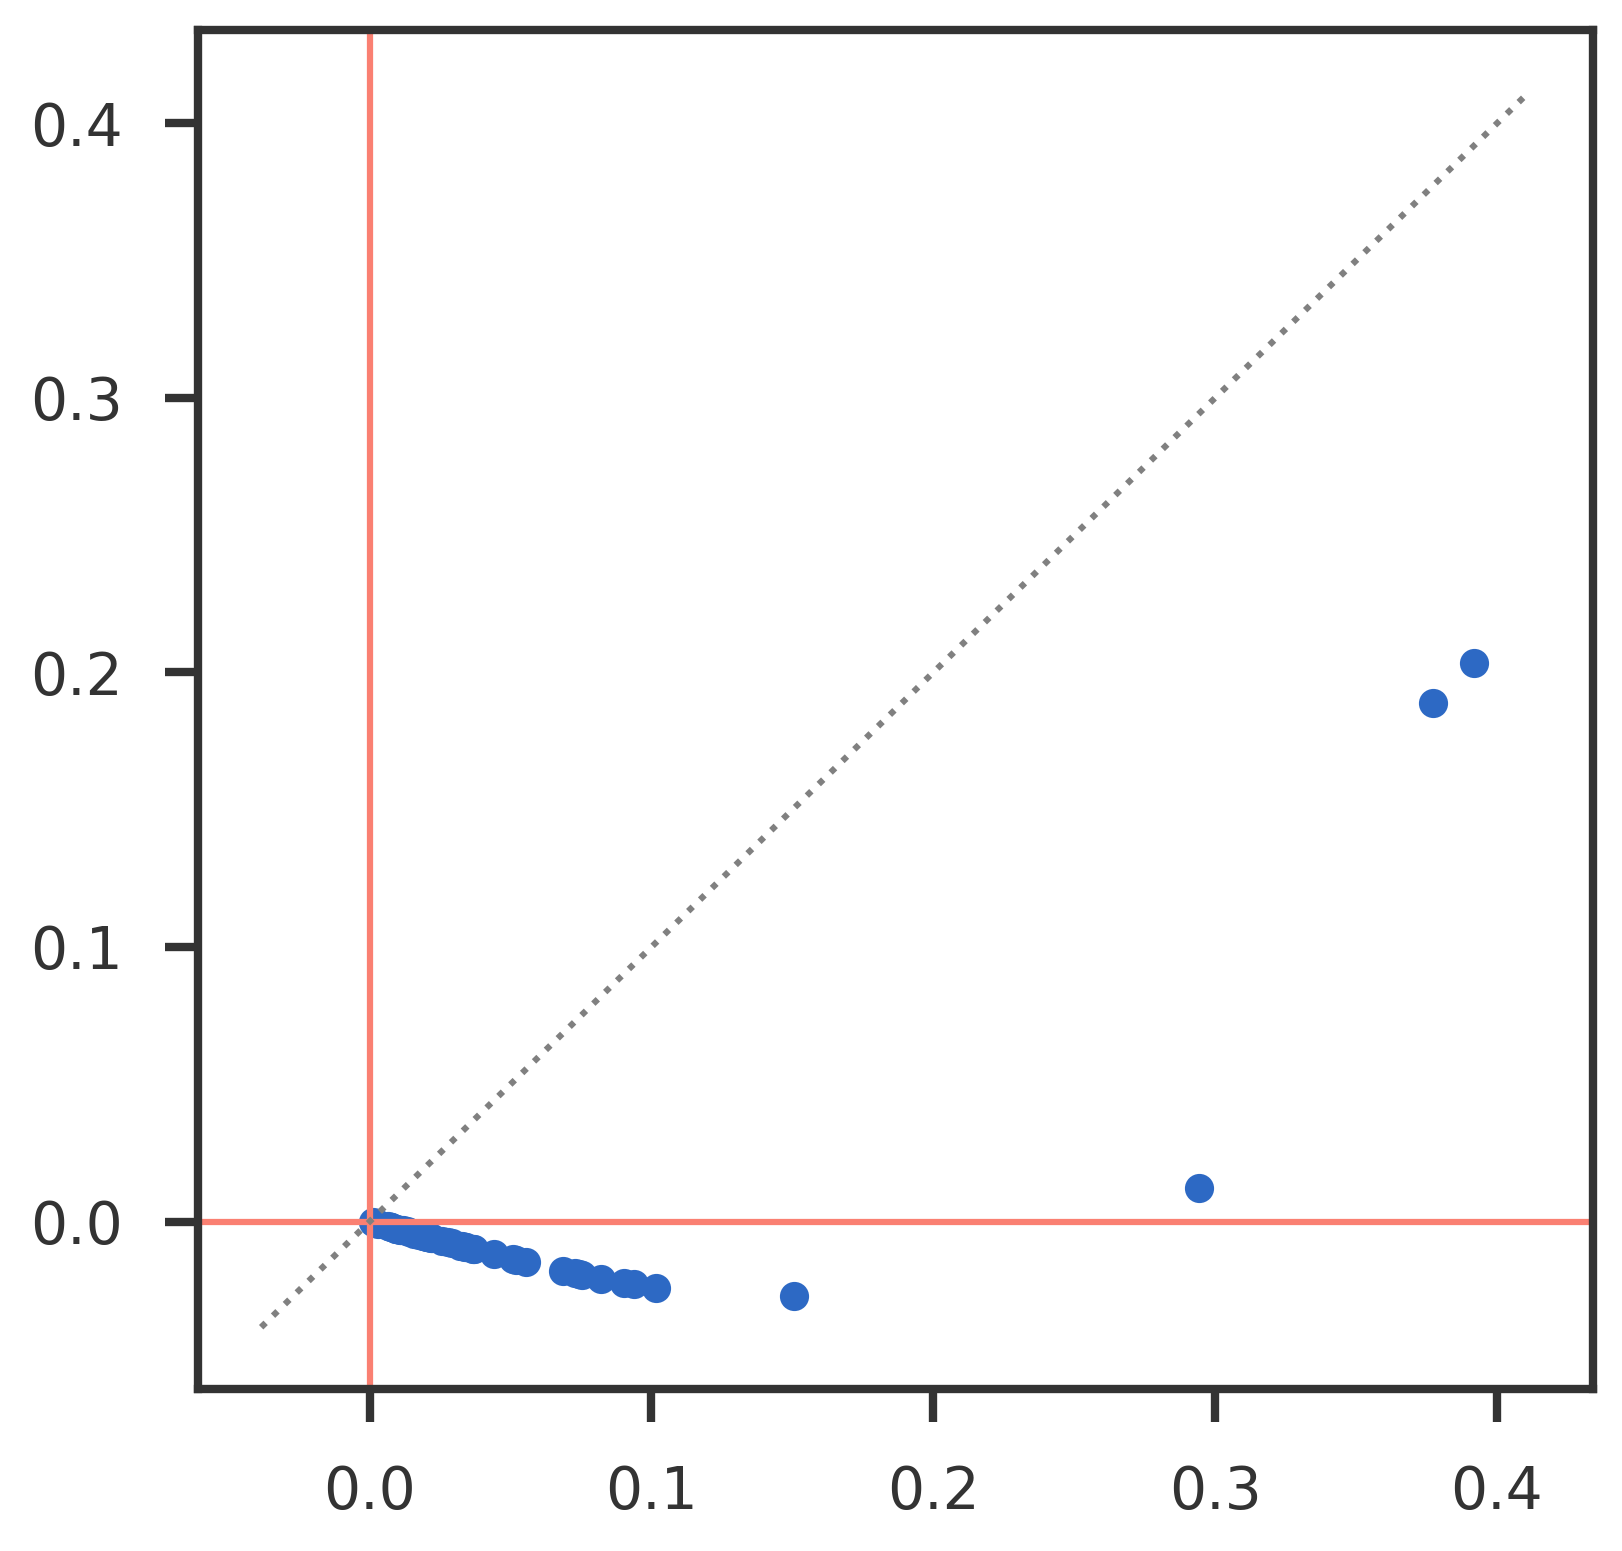

In [23]:
gt_one = 1.603
eps = np.std(b)

xup = b.copy()
xlo = b.copy()
ipos = np.where(b > 0)[0]
ineg = np.where(b < 0)[0]
xlo[ipos] -= eps
xup[ineg] += eps
#x[np.where(x > 0)] -= eps
#x *= np.sign(b)
#x = np.random.normal(b, 1, size = b.shape[0])

nfev = 0
tol = 1e-4
xup[ipos] *= gt_one
xlo[ineg] *= gt_one

print(ipos)

xev = xup.copy()
xev[ineg] = xlo[ineg]

niter = 0
while True:
    niter += 1
    fx = _rootfind_zero_func(xev, b, *fixargs)
    nfev += 1
    
    fneg = np.where(fx < tol)[0] # fx is always 1d
    fpos = np.where(fx > -tol)[0] 
    # Re-evaluate xup[ipos]
    stillneg = np.intersect1d(fneg, ipos)
    
    print(stillneg)
    
    # Re-evaluate xlo[ineg]
    stillpos = np.asarray(np.intersect1d(fpos, ineg))
    if stillneg.shape[0] == 0 and stillpos.shape[0] == 0:
        break
        
    if niter >= 2:
        break
        
    if stillneg.shape[0] > 0:
        print("Updating ipos values")
        xev[stillneg] *= gt_one
    if stillpos.shape[0] > 0:
        xev[stillpos] *= gt_one
xup[ipos] = xev[ipos]
xlo[ineg] = xev[ineg]
    

print (f"Number of function evaluations: {nfev}")
fxlo = _rootfind_zero_func(xlo, b, *fixargs)
fxup = _rootfind_zero_func(xup, b, *fixargs)

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
#ax1.scatter(xlo, fxlo)
ax1.scatter(xup[ipos], fxup[ipos])
ax1.axhline(y = 0, color = 'salmon')
ax1.axvline(x = 0, color = 'salmon')
mpl_utils.plot_diag(ax1)
plt.show()

Number of function evaluations: 12


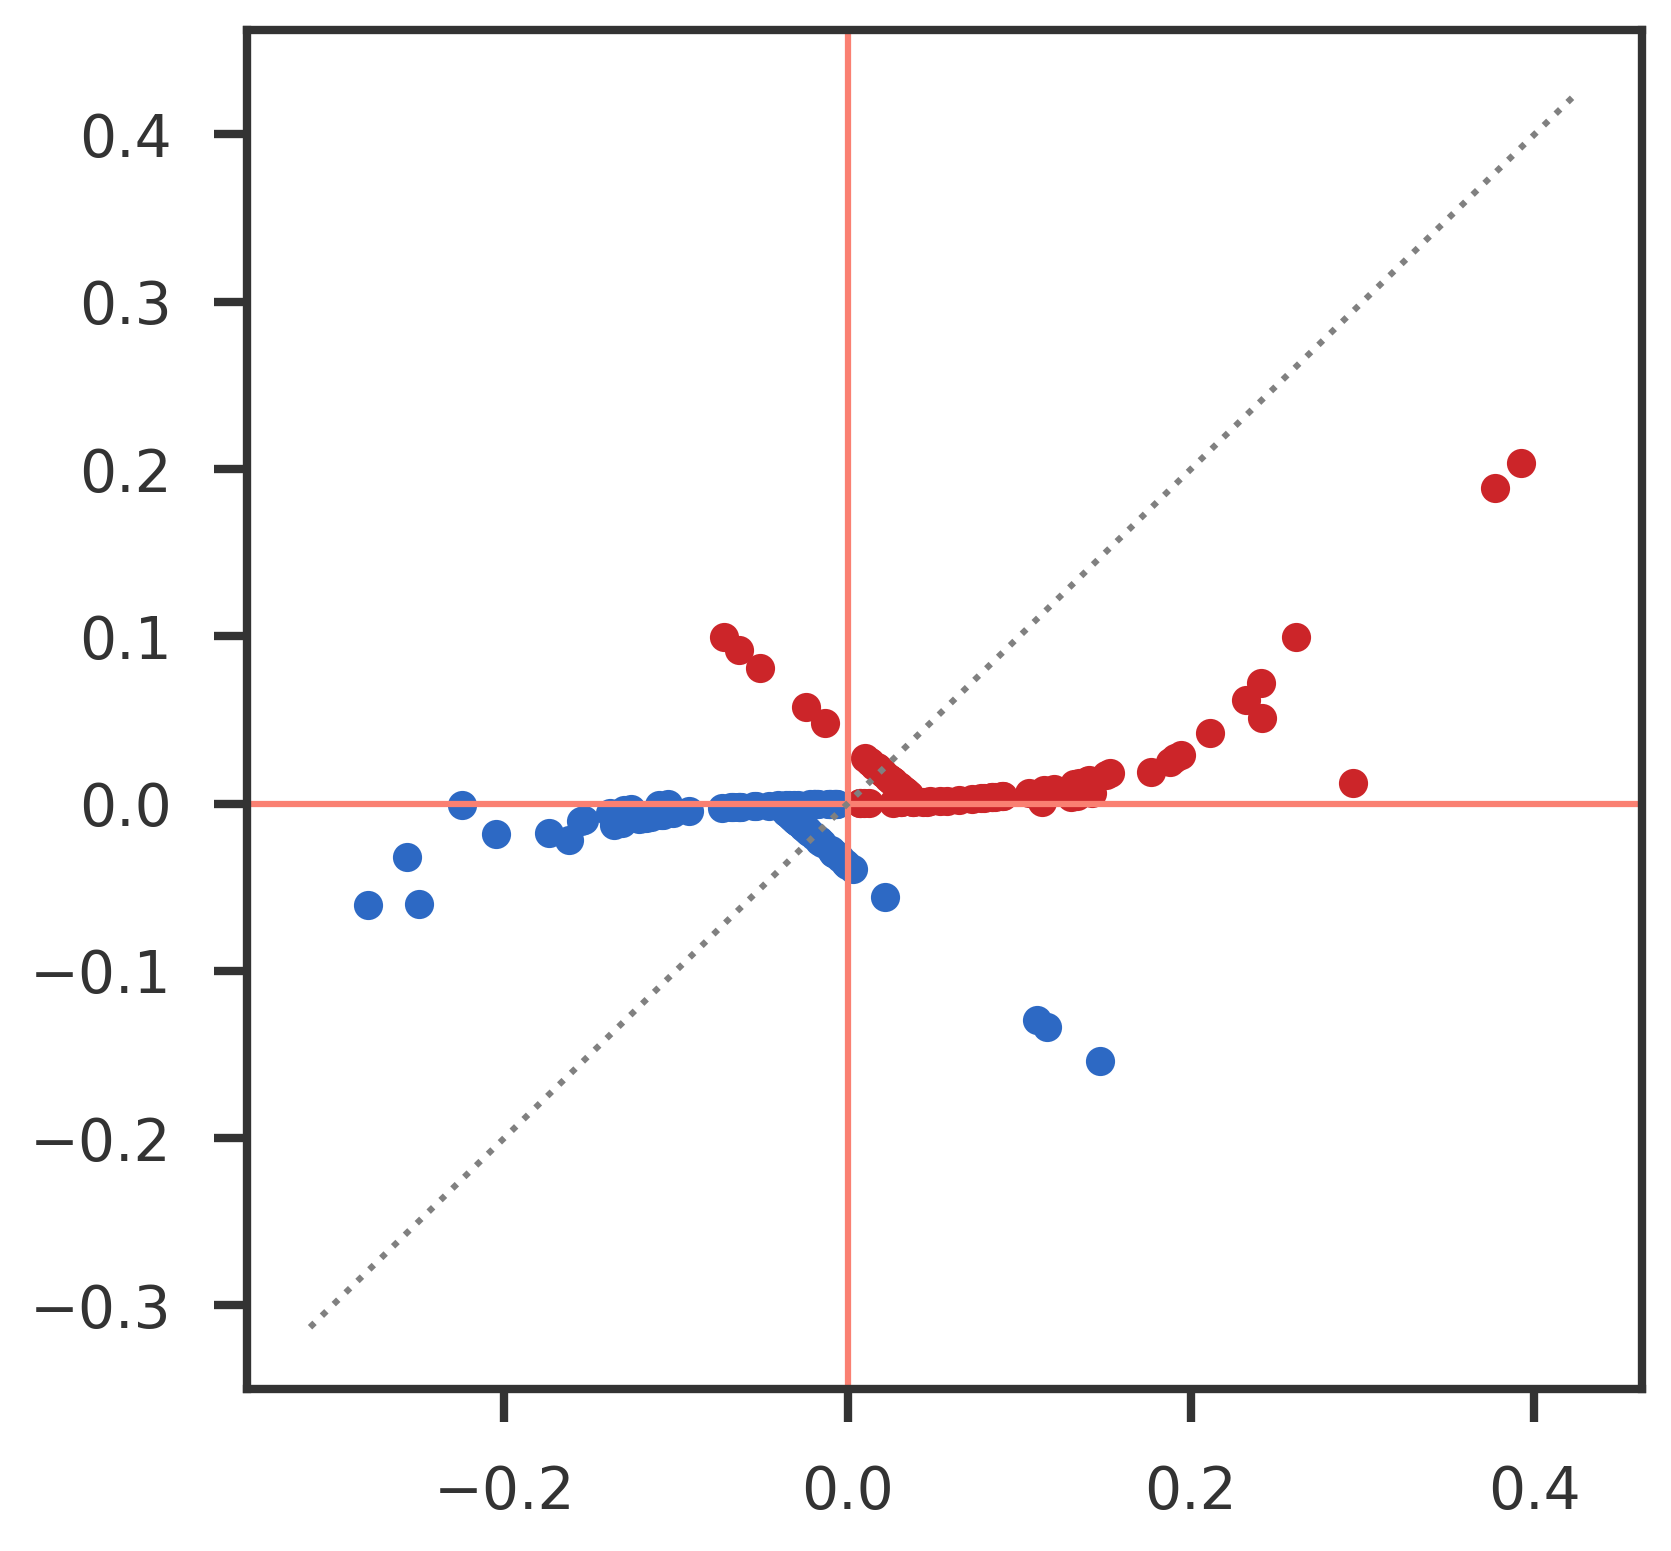

In [8]:
gt_one = 1.603
eps = np.std(b)

xup = b.copy()
xlo = b.copy()
ipos = np.where(b > 0)
ineg = np.where(b < 0)
xlo[ipos] -= eps
xup[ineg] += eps
#x[np.where(x > 0)] -= eps
#x *= np.sign(b)
#x = np.random.normal(b, 1, size = b.shape[0])

nfev = 0
tol = 1e-4
xup[ipos] *= gt_one
xlo[ineg] *= gt_one
#xup_est = xup.copy()
while True:
    fxup_est = _rootfind_zero_func(xup, b, *fixargs)
    nfev += 1
    fneg = np.where(fxup_est < tol)[0] # fxup_est is alway 1d
    
    if fneg.shape[0] == 0:
        break
    xup[fneg] *= gt_one
    
while True:
    fxlo_est = _rootfind_zero_func(xlo, b, *fixargs)
    nfev += 1
    fpos = np.where(fxlo_est > -tol)[0]
    
    if fpos.shape[0] == 0:
        break
    xlo[fpos] *= gt_one
    

print (f"Number of function evaluations: {nfev}")
fxlo = _rootfind_zero_func(xlo, b, *fixargs)
fxup = _rootfind_zero_func(xup, b, *fixargs)

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(xlo, fxlo)
ax1.scatter(xup, fxup)
ax1.axhline(y = 0, color = 'salmon')
ax1.axvline(x = 0, color = 'salmon')
mpl_utils.plot_diag(ax1)
plt.show()

True

In [61]:
np.all(fxlo < -tol)

True